## Section 1

In [26]:
#import 
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import time
np.random.seed(10)


In [27]:
"""
input: an array of the dimensions of each layer in the network (layer 0 is the size of the flattened input, layer L is the output softmax)

output: a dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL).
"""


def initialize_parameters(layer_dims):
    dicti = {}

    for i in range(len(layer_dims) - 1):
        dicti["W" + str(i + 1)] = np.random.randn(layer_dims[i + 1], layer_dims[i]) / layer_dims[i + 1]
        dicti["b" + str(i + 1)] = np.zeros((layer_dims[i + 1], 1))

    return dicti


In [28]:
"""
Description: Implement the linear part of a layer's forward propagation.

input: 
A  the activations of the previous layer
W  the weight matrix of the current layer (of shape [size of current layer, size of previous layer])
B the bias vector of the current layer (of shape [size of current layer, 1])

Output:
Z  the linear component of the activation function (i.e., the value before applying the non-linear function)
linear_cache  a dictionary containing A, W, b (stored for making the backpropagation easier to compute)

"""


def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    linear_cache = {"A": A, "W": W, "b": b}

    return Z, linear_cache



In [29]:
""" 
Input:
Z  the linear component of the activation function

Output:
A  the activations of the layer
activation_cache  returns Z, which will be useful for the backpropagation

"""


def softmax(Z):
    numerator = np.exp(Z)
    denominator = sum(np.exp(Z))
    A = numerator / denominator
    return A, Z


In [30]:
"""
Input:
Z  the linear component of the activation function

Output:
A  the activations of the layer

"""


def relu(Z):
    A = Z.copy()
    A[A < 0] = 0
    return A, Z

In [31]:
"""
Description:
Implement the forward propagation for the LINEAR->ACTIVATION layer

Input:
A_prev  activations of the previous layer
W  the weights matrix of the current layer
B  the bias vector of the current layer
Activation  the activation function to be used (a string, either “softmax” or “relu”)

Output:
A  the activations of the current layer
cache  a joint dictionary containing both linear_cache and activation_cache

"""


def linear_activation_forward(A_prev, W, B, activation):
    Z, linear_cache = linear_forward(A_prev, W, B)
    A, activation_cache = activation(Z)

    return A, {'linear_cache': linear_cache, 'activation_cache': activation_cache}


In [32]:
"""
Description:
performs batchnorm on the received activation values of a given layer.

Input:
A - the activation values of a given layer

output:
NA - the normalized activation values, based on the formula learned in class
"""


def apply_batchnorm(A):
    miu = np.mean(A)
    var = np.var(A)
    std = np.sqrt(var + 0.00000001)
    NA = (A - miu) / std
    return NA

In [33]:
"""
Description:
Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation

Input:
X – the data, numpy array of shape (input size, number of examples)
parameters – the initialized W and b parameters of each layer
use_batchnorm - a boolean flag used to determine whether to apply batchnorm after the activation (note that this option needs to be set to “false” in Section 3 and “true” in Section 4).

Output:
AL – the last post-activation value
caches – a list of all the cache objects generated by the linear_forward function

"""


def L_model_forward(X, parameters, use_batchnorm):
    A_prev = X
    caches = []
    for i in range(int(len(parameters) / 2) - 1):
        W = parameters["W" + str(i + 1)]
        B = parameters["b" + str(i + 1)]
        A, temp_cache = linear_activation_forward(A_prev, W, B, relu)
        caches.append(temp_cache)
        if use_batchnorm:
            A = apply_batchnorm(A)
        A_prev = A

    W = parameters["W" + str(int(len(parameters) / 2))]
    B = parameters["b" + str(int(len(parameters) / 2))]
    AL, cache = linear_activation_forward(A_prev, W, B, softmax)
    caches.append(cache)
    return AL, caches


In [34]:
"""
Description:
Implement the cost function defined by equation. The requested cost function is categorical cross-entropy loss

Input:
AL – probability vector corresponding to your label predictions, shape (num_of_classes, number of examples)
Y – the labels vector (i.e. the ground truth)

Output:
cost – the cross-entropy cost
"""


def compute_cost(AL, Y):
    inner_sigma = np.sum(Y * np.log(AL + 0.001), axis=0)
    m = Y.shape[1]
    cost = -1 / m * np.sum(inner_sigma)
    return cost



## Section 2

In [35]:
"""
description:
Implements the linear part of the backward propagation process for a single layer

Input:
dZ – the gradient of the cost with respect to the linear output of the current layer (layer l)
cache – tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

Output:
dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
dW -- Gradient of the cost with respect to W (current layer l), same shape as W
db -- Gradient of the cost with respect to b (current layer l), same shape as b

"""


def Linear_backward(dZ, cache):
    # A_prev, W, b = cache
    A_prev = cache['A']
    W = cache['W']
    b = cache['b']

    m = A_prev.shape[1]

    dW = 1 / m * dZ.dot(A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T.dot(dZ)

    return dA_prev, dW, db


In [36]:
"""
Description:
Implements backward propagation for a ReLU unit

Input:
dA – the post-activation gradient
activation_cache – contains Z (stored during the forward propagation)

Output:
dZ – gradient of the cost with respect to Z

"""


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.multiply(dA, np.where(Z > 0, 1, 0))
    return dZ


In [37]:
"""
Description:
Implements backward propagation for a softmax unit

Input:
dA – the post-activation gradient
activation_cache – contains Z (stored during the forward propagation)

Output:
dZ – gradient of the cost with respect to Z

"""


def softmax_backward(dA, activation_cache):
    dZ = dA - activation_cache
    return dZ


In [48]:
""" 
Description:
Implements the backward propagation for the LINEAR->ACTIVATION layer. The function first computes dZ and then applies the linear_backward function.

Input:
dA – post activation gradient of the current layer
cache – contains both the linear cache and the activations cache

Output:
dA_prev – Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
dW – Gradient of the cost with respect to W (current layer l), same shape as W
db – Gradient of the cost with respect to b (current layer l), same shape as b

"""


def linear_activation_backward(dA, cache, activation, keep_prob = 1.0):
    activation_cache = cache['activation_cache']
    linear_cache = cache['linear_cache']

    if activation == softmax:
        Y = cache['Y']
        dZ = softmax_backward(dA, Y)

    else:
        dZ = relu_backward(dA, activation_cache)

        # Implement the BONUS of the dropout regularization
        dZ *= np.random.rand(dZ.shape[0], dZ.shape[1]) < keep_prob
        dZ /= keep_prob

    return Linear_backward(dZ, linear_cache)



In [39]:
""" 
Description:
Implement the backward propagation process for the entire network.

Some comments:
the backpropagation for the softmax function should be done only once as only the output layers uses it and the RELU should be done iteratively over all the remaining layers of the network. 

Input:
AL - the probabilities vector, the output of the forward propagation (L_model_forward)
Y - the true labels vector (the "ground truth" - true classifications)
Caches - list of caches containing for each layer: a) the linear cache; b) the activation cache

Output:
Grads - a dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...

"""


def L_model_backward(AL, Y, caches, keep_prob=1.0):
    grads = {}

    for layer in reversed(range(len(caches))):
        curr_cache = caches[layer]

        if layer == len(caches) - 1:
            curr_cache['Y'] = Y
            dA_prev, dW, db = linear_activation_backward(AL, curr_cache, softmax)

        else:
            dA = dA_prev
            dA_prev, dW, db = linear_activation_backward(dA, curr_cache, relu, keep_prob)

        grads["dA" + str(layer + 1)] = dA_prev
        grads["dw" + str(layer + 1)] = dW
        grads["db" + str(layer + 1)] = db

    return grads


In [40]:
"""
Description:
Updates parameters using gradient descent

Input:
parameters – a python dictionary containing the DNN architecture’s parameters
grads – a python dictionary containing the gradients (generated by L_model_backward)
learning_rate – the learning rate used to update the parameters (the “alpha”)

Output:
parameters – the updated values of the parameters object provided as input

"""


def Update_parameters(parameters, grads, learning_rate):
    new_params = {}
    layers = int(len(parameters) / 2) + 1
    for layer in range(1, layers):
        old_W = parameters['W' + str(layer)]
        grad_W = grads['dw' + str(layer)]
        old_b = parameters['b' + str(layer)]
        grad_b = grads['db' + str(layer)]
        new_params['W' + str(layer)] = old_W - learning_rate * grad_W
        new_params['b' + str(layer)] = old_b - learning_rate * grad_b
    return new_params


## Section 3

In [41]:
"""
Description:
Implements a L-layer neural network. All layers but the last should have the ReLU activation function, and the final layer will apply the softmax activation function. The size of the output layer should be equal to the number of labels in the data. Please select a batch size that enables your code to run well (i.e. no memory overflows while still running relatively fast).

Hint: the function should use the earlier functions in the following order: initialize -> L_model_forward -> compute_cost -> L_model_backward -> update parameters

Input:
X – the input data, a numpy array of shape (height*width , number_of_examples) 
Comment: since the input is in grayscale we only have height and width, otherwise it would have been height*width*3
Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
Layer_dims – a list containing the dimensions of each layer, including the input
batch_size – the number of examples in a single training batch.

Output:
parameters – the parameters learnt by the system during the training (the same parameters that were updated in the update_parameters function).
costs – the values of the cost function (calculated by the compute_cost function). One value is to be saved after each 100 training iterations (e.g. 3000 iterations -> 30 values).
"""


def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, keep_prob=1.0):
    parameters = initialize_parameters(layers_dims)
    costs_train = []
    costs_validation = []

    batchnorm = False

    # the following divide the training and validation, and shuffle teh records.
    train_frac = 0.8
    n_samples = X.shape[1]
    shuffled_indices = np.random.permutation(n_samples)
    train_indices = shuffled_indices[:int(train_frac * n_samples)]
    valid_indices = shuffled_indices[int(train_frac * n_samples):]
    X_train, X_valid = X[:, train_indices], X[:, valid_indices]
    Y_train, Y_valid = Y[:, train_indices], Y[:, valid_indices]

    num_batches = X_train.shape[1] // batch_size
    counter_of_batches = 1
    for epoch in range(num_iterations):
        for j in range(num_batches):
            batch_X = X_train[:, j * batch_size:(j + 1) * batch_size]
            batch_Y = Y_train[:, j * batch_size:(j + 1) * batch_size]

            AL_train, caches_train = L_model_forward(batch_X, parameters, batchnorm)

            grads = L_model_backward(AL_train, batch_Y, caches_train, keep_prob)
            parameters = Update_parameters(parameters, grads, learning_rate)

            if counter_of_batches % 100 == 0:
                cost_train = compute_cost(AL_train, batch_Y)
                costs_train.append(cost_train)

                # Now check on the validation
                AL_validation, cache_validation = L_model_forward(X_valid, parameters, batchnorm)
                cost_validation = compute_cost(AL_validation, Y_valid)
                costs_validation.append(cost_validation)
                # early stopping criterion
                if len(costs_validation) >= 2 and np.abs(costs_validation[-1] - costs_validation[-2]) < 0.0001:
                    print_details(X_train, X_valid, Y_train, Y_valid, costs_train, parameters, epoch, costs_validation,
                                  counter_of_batches, batchnorm)
                    return parameters, costs_train, costs_validation, int(counter_of_batches//100)
            counter_of_batches += 1

        if len(costs_validation) > 1 and len(costs_train) > 1:
            print(f"Epoch number {epoch}, the cost train {costs_train[-1]} and the cost validation is {costs_validation[-1]}")

    print_details(X_train, X_valid, Y_train, Y_valid, costs_train, parameters, epoch, costs_validation,
                  counter_of_batches, batchnorm)

    return parameters, costs_train, costs_validation, int(counter_of_batches//100)


In [42]:
"""
This function is a helper function that prints the details of the running
"""
def print_details(X_train, X_valid, Y_train, Y_valid, costs_train, parameters, epoch, costs_validation,counter_of_batches, batchnorm):
    train_accuracy = Predict(X_train, Y_train, parameters, batchnorm)
    validation_accuracy = Predict(X_valid, Y_valid, parameters, batchnorm)
    print(f'Number of Epoch: {epoch + 1}')
    print(f'Number of Iteration: {counter_of_batches}')
    print(f'Train Cost: {round(costs_train[-1], 4)}')
    print(f'Validation Cost: {round(costs_validation[-1], 4)}')
    print(f'Train Accuracy: {round(train_accuracy, 4)} %')
    print(f'Validation Accuracy: {round(validation_accuracy, 4)} %')

In [43]:
""" 
Description:
The function receives an input data and the true labels and calculates the accuracy of the trained neural network on the data.

Input:
X – the input data, a numpy array of shape (height*width, number_of_examples)
Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
Parameters – a python dictionary containing the DNN architecture’s parameters

Output:
accuracy – the accuracy measure of the neural net on the provided data (i.e. the percentage of the samples for which the correct label receives the hughest confidence score). Use the softmax function to normalize the output values.
"""


def Predict(X, Y, parameters, batchnorm):
    AL, caches = L_model_forward(X, parameters, batchnorm)
    Y_pred = np.argmax(AL, axis=0)
    Y_true = np.argmax(Y, axis=0)
    accuracy = np.mean(Y_pred == Y_true) * 100

    return accuracy

## Section 4

In [44]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Parameters
layers = 4
layers_dims = [20, 7, 5, 10]

# normalize the dataset by 255 (max value)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the X and process the Y (one hot)
x_train_flatten = x_train.reshape((x_train.shape[0], 784), order='F')
x_test_flatten = x_test.reshape((x_test.shape[0], 784), order='F')
y_train_encoded = np.eye(10)[y_train]
y_test_encoded = np.eye(10)[y_test]

# learning rate
learning_rate = 0.009

# TRAIN
layers_dims = [x_train_flatten.shape[1]] + layers_dims

In [45]:
# start the training procedure and print the details
start = time.time()

parameters, costs_train, costs_validation, iteration = L_layer_model(x_train_flatten.T, y_train_encoded.T, layers_dims, learning_rate, 100, 128, 0.5)

end = time.time()

test_accuracy = Predict(x_test_flatten.T, y_test_encoded.T, parameters, False)

print(f'Test Accuracy: {round(test_accuracy, 4)} %')
print(f"The running time is {round(end-start,2)} seconds.")


arr_iter = [i for i in range(1,iteration+1)]


# keep_arr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]







Epoch number 0, the cost train 2.2906446058557304 and the cost validation is 2.2915840646584225
Epoch number 1, the cost train 2.2871291858756786 and the cost validation is 2.290581191473015
Epoch number 2, the cost train 2.292182222164195 and the cost validation is 2.289593982857714
Epoch number 3, the cost train 2.289067973927125 and the cost validation is 2.2881861361013405
Epoch number 4, the cost train 2.2833515156990045 and the cost validation is 2.286536934125714
Epoch number 5, the cost train 2.275766178057406 and the cost validation is 2.2825007308973695
Epoch number 6, the cost train 2.278830816579183 and the cost validation is 2.272977898921775
Epoch number 7, the cost train 2.2430270058139206 and the cost validation is 2.2419341779201076
Epoch number 8, the cost train 2.1461157352871125 and the cost validation is 2.1623507067148497
Epoch number 9, the cost train 1.8828211668066759 and the cost validation is 1.8967196812528444
Epoch number 10, the cost train 1.76004531049485

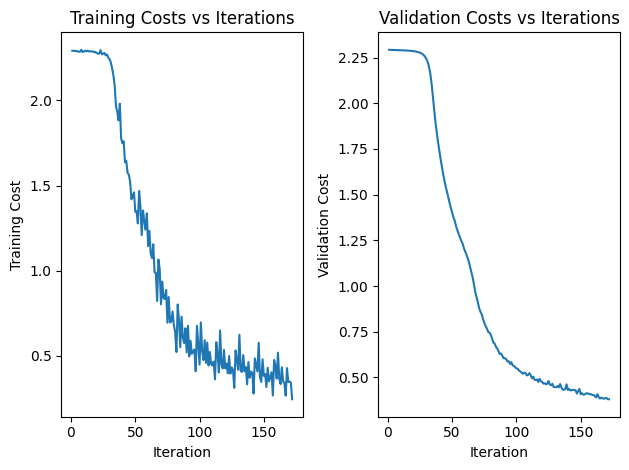

In [46]:
##The following is drawing the training cost vs the validation cost on the iteration number
# plot left graph
plt.subplot(1, 2, 1)
plt.plot(arr_iter, costs_train)
plt.xlabel('Iteration')
plt.ylabel('Training Cost')
plt.title('Training Costs vs Iterations')

# plot right graph
plt.subplot(1, 2, 2)
plt.plot(arr_iter, costs_validation)
plt.xlabel('Iteration')
plt.ylabel('Validation Cost')
plt.title('Validation Costs vs Iterations')

# show plot
plt.tight_layout()
plt.show()

In [47]:

# CODE FOR DRAWING THE BATCH
# import matplotlib.pyplot as plt
#
# x = [16, 32, 64, 128, 256, 512, 1024, 2048]
# y = [10.28, 85.64, 87.18, 92.32, 90.99, 88.92, 69.45, 27.33]
# batch_num = [str(b) for b in x]
#
# fig, ax = plt.subplots()
# ax.plot(x, y, marker='o')
#
# plt.xticks(x[::2] + [1024] + x[-1:], batch_num[::2] + ['1024'] + batch_num[-1:])
# ax.set_xlabel('Batch Size')
# ax.set_ylabel('Test Accuracy')
# ax.set_title('Accuracy vs Batch Size')
#
# plt.show()


# # CODE FOR DRAWING THE DROPOUT
# #
# import matplotlib.pyplot as plt
# x = keep_arr
# y = test_arr
#
# fig, ax = plt.subplots()
# ax.plot(x, y, marker='o')
#
# ax.set_xlabel('Keep Probability (Dropout)')
# ax.set_ylabel('Test Accuracy')
# ax.set_title('Accuracy vs Dropout')
#
# plt.show()